In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Explicitly enable experimental features
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, QuantileTransformer,
    OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer, KBinsDiscretizer
)
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans


sns.set_theme(style="whitegrid")

In [6]:
df = pd.read_csv("../Data/Train.csv")

print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (10999, 12)


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [18]:
np.random.seed(101)

rows = 1200

synthetic_df = pd.DataFrame({

    "Warehouse_block": np.random.choice(list("ABCDF"), rows),

    "Mode_of_Shipment": np.random.choice(
        ["Flight", "Ship", "Road", None], rows, p=[0.35,0.35,0.2,0.1]
    ),

    "Customer_care_calls": np.random.randint(2,8,rows),

    "Customer_rating": np.random.randint(1,6,rows),

    # skewed distribution
    "Cost_of_the_Product": np.random.gamma(3,70,rows),

    "Prior_purchases": np.random.randint(1,10,rows),

    "Product_importance": np.random.choice(
        ["low","medium","high"], rows, p=[0.5,0.3,0.2]
    ),

    "Gender": np.random.choice(["M","F"], rows),

    # heavy right skew
    "Discount_offered": np.random.lognormal(2.2,0.6,rows).astype(int),

    "Weight_in_gms": np.random.normal(3800,1100,rows),

    "Reached.on.Time_Y.N": np.random.randint(0,2,rows)
})

print("Synthetic Dataset Created ✔")
synthetic_df.head()

Synthetic Dataset Created ✔


,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Ship,6,4,154.740329,5,low,F,3,3969.295716,1
1,B,Flight,3,3,307.390877,6,low,F,8,3154.652665,1
2,D,Road,6,5,309.646391,1,low,F,22,2764.908255,1
3,B,Ship,6,4,136.076026,5,medium,M,10,2458.620082,1
4,A,Road,5,3,464.741377,6,low,M,3,3467.106643,1


In [7]:
target = "Reached.on.Time_Y.N"

features = df.drop(columns=[target], errors="ignore")
labels = df[target]

print("Features:", features.shape)
print("Labels:", labels.shape)

Features: (10999, 11)
Labels: (10999,)


In [8]:
num_cols = features.select_dtypes(include=np.number).columns.tolist()
cat_cols = features.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
Categorical: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


In [9]:
numeric_pipe = Pipeline([
    ("knn_impute", KNNImputer(n_neighbors=3)),
    ("robust_scale", RobustScaler())
])

In [10]:
categorical_pipe = Pipeline([
    ("cat_impute", SimpleImputer(strategy="most_frequent")),
    ("encoding", OneHotEncoder(handle_unknown="ignore"))
])

In [11]:
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

preprocess

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [12]:
X_processed = preprocess.fit_transform(features)

print("Processed Shape:", X_processed.shape)

Processed Shape: (10999, 20)


In [13]:
iso_model = IsolationForest(contamination=0.04, random_state=42)

features["outlier_flag"] = iso_model.fit_predict(features[num_cols])

print(features["outlier_flag"].value_counts())

outlier_flag
 1    10559
-1      440
Name: count, dtype: int64


In [19]:
iso_data = synthetic_df[["Weight_in_gms","Cost_of_the_Product","Discount_offered"]].fillna(0)

iso_model = IsolationForest(contamination=0.05, random_state=101)

flags = iso_model.fit_predict(iso_data)

synthetic_clean = synthetic_df[flags == 1]

print("Synthetic Outliers Removed:", len(synthetic_df)-len(synthetic_clean))

Synthetic Outliers Removed: 60


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_1400\1975563128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_clean["Cost_normalized"] = qt.fit_transform(


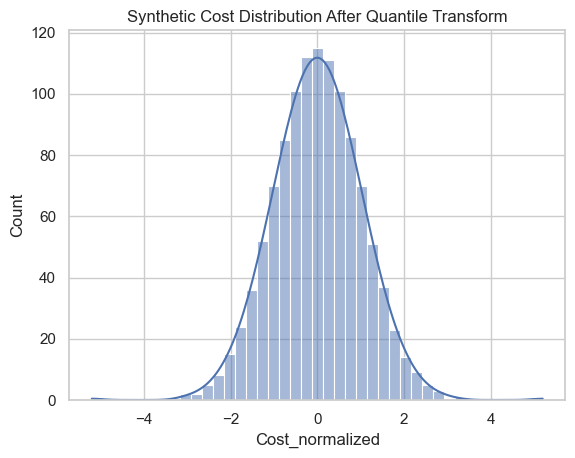

In [21]:
qt = QuantileTransformer(output_distribution="normal")

synthetic_clean["Cost_normalized"] = qt.fit_transform(
    synthetic_clean[["Cost_of_the_Product"]]
)

sns.histplot(synthetic_clean["Cost_normalized"], kde=True)
plt.title("Synthetic Cost Distribution After Quantile Transform")
plt.show()

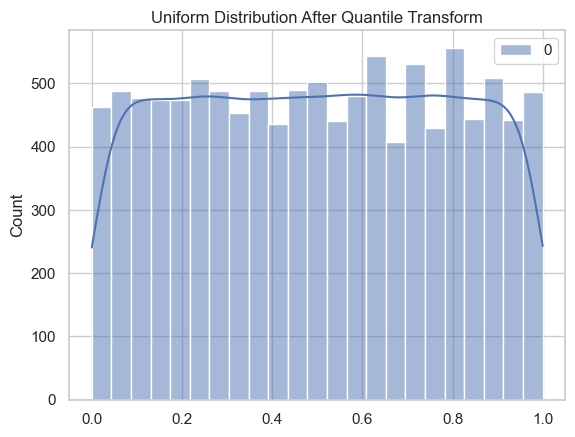

In [14]:
qt = QuantileTransformer(output_distribution="uniform")

qt_values = qt.fit_transform(df[["Cost_of_the_Product"]])

sns.histplot(qt_values, kde=True)
plt.title("Uniform Distribution After Quantile Transform")
plt.show()

In [15]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(X_processed)

print("PCA Shape:", pca_data.shape)

PCA Shape: (10999, 2)


In [16]:
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

mice_data = mice_imputer.fit_transform(
    df[['Cost_of_the_Product','Weight_in_gms','Discount_offered']]
)

print("MICE Output Shape:", mice_data.shape)

MICE Output Shape: (10999, 3)
